# Vpliv izobrazbe na brezposelnost

In [478]:
# importamo podatke iz deljenega diska
%store -r data_dict
data_dict = data_dict # da bo linter miren
data_dict.keys()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [479]:
STOPNJE = ['1+2              OŠ ali manj',
       '3+4 - nižje, srednje poklicno izobr.',
       '5 - srednje tehniško, strokovno, splošno izobr.',
       '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje']
po_regijah_izobrazba = data_dict['po-statisticnah-regijah_izobrazba']
# sort by year descending
po_regijah_izobrazba = po_regijah_izobrazba.sort_values(by='__leto', ascending=False)
po_regijah_izobrazba.head()

,Kohezijska / Statistična regija,1+2 OŠ ali manj,"3+4 - nižje, srednje poklicno izobr.","5 - srednje tehniško, strokovno, splošno izobr.","6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje",Skupaj,month,year,__regija,__leto
949,Občina izven RS,824.0,38.0,26.0,79.0,967.0,FEB,2023,Občina izven RS,2023
921,Savinjska,2458.0,2218.0,2050.0,1325.0,8051.0,JAN,2023,Savinjska,2023
928,Osrednjeslovenska,3936.0,2860.0,3676.0,2786.0,13258.0,JAN,2023,Osrednjeslovenska,2023
927,Obalno-kraška,923.0,720.0,892.0,539.0,3074.0,JAN,2023,Obalno-kraška,2023
926,Goriška,595.0,443.0,508.0,425.0,1971.0,JAN,2023,Goriška,2023


## Brezposlenost po izobrazbi

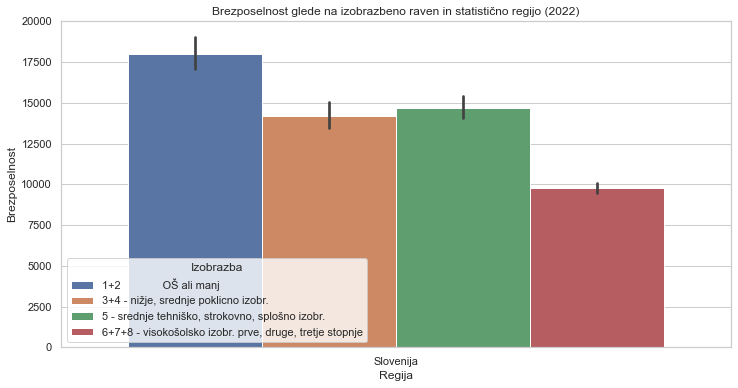

In [480]:
data = data_dict['po-statisticnah-regijah_izobrazba']

data = data.dropna()

data.columns = data.columns.str.strip()

data = data.rename(columns={
    'Kohezijska / Statistična regija': 'Region',
    'Skupaj': 'Total'
})
data = data.query("__leto == 2022")
data = data.query("Region == 'Slovenija'")

melted_data = pd.melt(data, id_vars=['Region', 'year'], value_vars=STOPNJE, var_name='Izobrazba', value_name='Unemployment')

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=melted_data, x='Region', y='Unemployment', hue='Izobrazba', ax=ax)

ax.set_title('Brezposelnost glede na izobrazbeno raven in statistično regijo (2022)')
ax.set_xlabel('Regija')
ax.set_ylabel('Brezposelnost')

plt.show()


Iz grafa lahko razberemo da je brezposelnost visja med osebami z nizjo izobrazbo. Vendar nam to ne pove da je vzrok za visjo brezposelnost definitivno nizka izobrazba. Vzrokov je lahko vec. Lahko je delez oseb z nizjo izobrazbo vecji kot oseb z visjo izobrazbo. Lahko je tudi obratno, da je vzrok za nizko izobrazbo brezposelnost.
Zanimivo, pa je v letu 2022 imela 5. stopnja izobrazbe visjo brezposelnost kot 3. + 4. stopnja izobrazbe.  

## Brezposelnost po izobrazbi (v odstotkih)

Da lahko zgornji grafikon pretvorimo v odstotke potrebujemo podatke o izobrazbi vseh zaposlenih in brezposelnih slovenskih drzavljanov.

In [481]:
# Read the file using the detected encoding
zaposleni = pd.read_csv('structured_data/zaposleni/prebivalstvo_po_statusu_akitivnosti.csv', sep=',', encoding="Windows-1252")
zaposleni = zaposleni.dropna()
zaposleni.head()

,SPOL,IZOBRAZBA,2011 Zaposleni,2011 Brezposelni,2012 Zaposleni,2012 Brezposelni,2013 Zaposleni,2013 Brezposelni,2014 Zaposleni,2014 Brezposelni,...,2018 Zaposleni,2018 Brezposelni,2019 Zaposleni,2019 Brezposelni,2020 Zaposleni,2020 Brezposelni,2021 Zaposleni,2021 Brezposelni,2022 Zaposleni,2022 Brezposelni
0,Spol - SKUPAJ,Izobrazba - SKUPAJ,835776,108793,824636,114166,803082,119307,800018,125900,...,875484,87657,899776,81104,911111,79636,917009,92883,930965,72568
1,Spol - SKUPAJ,Osnovnošolska ali manj - Skupaj,121766,30186,107067,29816,95233,28009,90280,28049,...,77109,18804,76347,17482,76812,17068,80951,18070,79937,15268
2,Spol - SKUPAJ,Brez izobrazbe,105,23,80,51,72,18,67,13,...,68,5,71,4,152,5,163,5,138,4
3,Spol - SKUPAJ,Nepopolna osnovnošolska,13413,154,10806,817,8753,128,8000,252,...,5657,731,5610,730,6213,797,7218,945,7471,979
4,Spol - SKUPAJ,Osnovnošolska,108248,30009,96181,28948,86408,27863,82213,27784,...,71384,18068,70666,16748,70447,16266,73570,17120,72328,14285


Naletimo na problem: grupiranje nivojev izobrazbe se razlikuje med podatkovnima viroma. Zato moramo nivoje izobrazbe v podatkih o zaposlenih pretvoriti v nivoje izobrazbe v podatkih o brezposelnih.

In [482]:
# Define the mapping
education_mapping = {
    'Osnovnošolska ali manj - Skupaj': '1+2 OŠ ali manj',
    'Brez izobrazbe': '1+2 OŠ ali manj',
    'Nepopolna osnovnošolska': '1+2 OŠ ali manj',
    'Osnovnošolska': '1+2 OŠ ali manj',
    'Srednješolska - Skupaj': '3+4 - nižje, srednje poklicno izobr.',
    'Nižja poklicna': '3+4 - nižje, srednje poklicno izobr.',
    'Srednja poklicna': '3+4 - nižje, srednje poklicno izobr.',
    'Srednja strokovna, srednja splošna': '5 - srednje tehniško, strokovno, splošno izobr.',
    'Višješolska, visokošolska - Skupaj': '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje',
    'Višješolska (prejšnja), višja strokovna': '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje',
    'Visokošolska 1. stopnje, visokošolska strokovna (prejšnja) ipd.': '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje',
    'Visokošolska 2. stopnje, visokošolska univerzitetna (prejšnja) ipd.': '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje',
    'Magisterij znanosti ipd.': '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje',
    'Doktorat znanosti': '6+7+8 - visokošolsko izobr. prve, druge, tretje stopnje'
}

# Apply the mapping
zaposleni['IZOBRAZBA'] = zaposleni['IZOBRAZBA'].map(education_mapping)
zaposleni.head()

,SPOL,IZOBRAZBA,2011 Zaposleni,2011 Brezposelni,2012 Zaposleni,2012 Brezposelni,2013 Zaposleni,2013 Brezposelni,2014 Zaposleni,2014 Brezposelni,...,2018 Zaposleni,2018 Brezposelni,2019 Zaposleni,2019 Brezposelni,2020 Zaposleni,2020 Brezposelni,2021 Zaposleni,2021 Brezposelni,2022 Zaposleni,2022 Brezposelni
0,Spol - SKUPAJ,NaN,835776,108793,824636,114166,803082,119307,800018,125900,...,875484,87657,899776,81104,911111,79636,917009,92883,930965,72568
1,Spol - SKUPAJ,1+2 OŠ ali manj,121766,30186,107067,29816,95233,28009,90280,28049,...,77109,18804,76347,17482,76812,17068,80951,18070,79937,15268
2,Spol - SKUPAJ,1+2 OŠ ali manj,105,23,80,51,72,18,67,13,...,68,5,71,4,152,5,163,5,138,4
3,Spol - SKUPAJ,1+2 OŠ ali manj,13413,154,10806,817,8753,128,8000,252,...,5657,731,5610,730,6213,797,7218,945,7471,979
4,Spol - SKUPAJ,1+2 OŠ ali manj,108248,30009,96181,28948,86408,27863,82213,27784,...,71384,18068,70666,16748,70447,16266,73570,17120,72328,14285


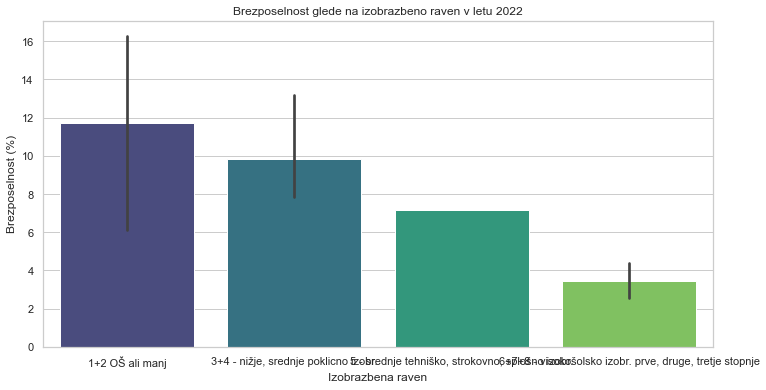

In [483]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named zaposleni

# Calculate the unemployment rate for each education level
zaposleni['2022 Unemployment Rate'] = (zaposleni['2022 Brezposelni'] / (zaposleni['2022 Zaposleni'] + zaposleni['2022 Brezposelni'])) * 100

# Filter out the rows where 'IZOBRAZBA' is NaN
zaposleni_filtered = zaposleni[zaposleni['IZOBRAZBA'].notna()]

# Prepare data for seaborn
melted_data = zaposleni_filtered[['IZOBRAZBA', '2022 Unemployment Rate']].copy()

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=melted_data, x='IZOBRAZBA', y='2022 Unemployment Rate', ax=ax, palette='viridis')

ax.set_title('Brezposelnost glede na izobrazbeno raven v letu 2022')
ax.set_xlabel('Izobrazbena raven')
ax.set_ylabel('Brezposelnost (%)')

plt.show()


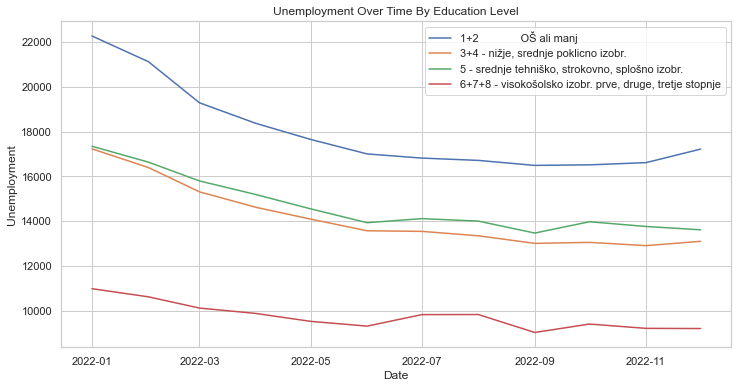

In [484]:
# Create a mapping from Slovenian month names to English
month_mapping = {
    'JAN': 'Jan',
    'FEB': 'Feb',
    'MAR': 'Mar',
    'APR': 'Apr',
    'MAJ': 'May',
    'JUN': 'Jun',
    'JUL': 'Jul',
    'AVG': 'Aug',
    'SEP': 'Sep',
    'OKT': 'Oct',
    'NOV': 'Nov',
    'DEC': 'Dec'
}

# Convert Slovenian months to English
data['month'] = data['month'].map(month_mapping)

# Now we can convert to datetime
data['Date'] = pd.to_datetime(data['year'].astype(str) + data['month'], format='%Y%b')
data = data.sort_values(by='Date')

# Melt the data
melted_data = pd.melt(data, id_vars=['Date', 'Region'], value_vars=STOPNJE, var_name='Izobrazba', value_name='Unemployment')

# Plot the data
plt.figure(figsize=(12,6))
for education_level in STOPNJE:
    subset = melted_data[melted_data['Izobrazba'] == education_level]
    plt.plot(subset['Date'], subset['Unemployment'], label=education_level)

plt.xlabel('Date')
plt.ylabel('Unemployment')
plt.title('Unemployment Over Time By Education Level')
plt.legend()
plt.show()